# Application of ML pipeline on dataset generated after simple imputation (median) of missing values in PIMA diabetes dataset:
- We will initialize the some classifier models with their default parameters and add them to a model list and apply on the dataset generated after imputation of impossible zeros by the median of corresponding column from the original dataset.

- When we fit aforesaid models a loop on the median imputed dataset ,we get the accuracy of the respective model using the “accuracy_score”

# Import necessary libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

# Read the median Imputed dataset

In [2]:
#Loading the modified dataset (dataset that we generated in after median imputation of missing values in PIMA diabetes dataset
diabetes_df_median = pd.read_csv("diabetes_df_median.csv")

# Define X and y

In [3]:
X_median = diabetes_df_median[diabetes_df_median.columns[:-1]]
y_median = diabetes_df_median.Outcome

# Scaling the data

In [4]:
scaler = StandardScaler()
X_median_scaled = scaler.fit_transform(X_median)

# Train-test split of data

In [5]:
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median_scaled, y_median, stratify=diabetes_df_median.Outcome,random_state=0)



# ML Models

In [6]:
models = []
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVC', SVC()))
models.append(('LR', LogisticRegression()))
models.append(('DT', DecisionTreeClassifier()))
models.append(('GNB', GaussianNB()))
models.append(('RF', RandomForestClassifier()))
models.append(('GB', GradientBoostingClassifier()))

In [7]:
names = []
scores = []
for name, model in models:
    model.fit(X_median_train, y_median_train)
    y_pred_median = model.predict(X_median_test)
    scores.append(accuracy_score(y_median_test, y_pred_median))
    names.append(name)
tr_split = pd.DataFrame({'Name': names, 'Score': scores})
print(tr_split)

  Name     Score
0  KNN  0.713542
1  SVC  0.760417
2   LR  0.750000
3   DT  0.713542
4  GNB  0.750000
5   RF  0.770833
6   GB  0.776042


# Stratified K-Fold Cross-Validation

In [8]:
names = []
scores = []
for name, model in models:
    
    skfold = StratifiedKFold(n_splits=10) 
    score = cross_val_score(model, X_median_scaled, y_median, cv=skfold, scoring='accuracy').mean()
    
    names.append(name)
    scores.append(score)
skf_cross_val = pd.DataFrame({'Name': names, 'Score': scores})
print(skf_cross_val)

  Name     Score
0  KNN  0.751213
1  SVC  0.753913
2   LR  0.766951
3   DT  0.687628
4  GNB  0.750000
5   RF  0.763038
6   GB  0.765636


But after stratifiedK fold cross validation, accuracy score of all models changed. We can see from the table, that LR is the best performing model having accuracy increased to 76.70%  followed by  GB having accuracy 76.56%.

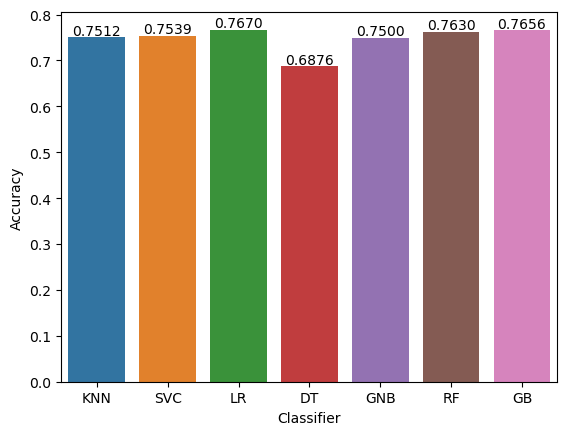

In [9]:
axis = sns.barplot(x = 'Name', y = 'Score', data = skf_cross_val)
axis.set(xlabel='Classifier', ylabel='Accuracy')
for p in axis.patches:
    height = p.get_height()
    axis.text(p.get_x() + p.get_width()/2, height + 0.005, '{:1.4f}'.format(height), ha="center") 
    
plt.show()

# Logistic Regression — Feature Selection

At the baseline LR managed to achieve a classification accuracy of 76.70 %. This will be selected as the prime candidate for the next phases alongwith GB which is second best performing model having accuracy 76.56%.
We know that all predictors do not equally contribute to the outcome variable so most of the time, there are variables that don’t improve the model. Such cases can be found by further analysis of the features related to the model. So after model selection, Feature Engineering should be considered. Therefore we will be analyzing the selected model which is LR, and how feature importance affects it.

In [10]:
logreg_model = LogisticRegression()
rfecv = RFECV(estimator=logreg_model, step=1, cv=skfold, scoring='accuracy')
rfecv.fit(X_median_scaled, y_median)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=LogisticRegression(), scoring='accuracy')

RFE works by recursively removing attributes and building a model on those attributes that remain and it employs the model accuracy to identify which attributes (and combination of attributes) contribute the most to predicting the target attribute.

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


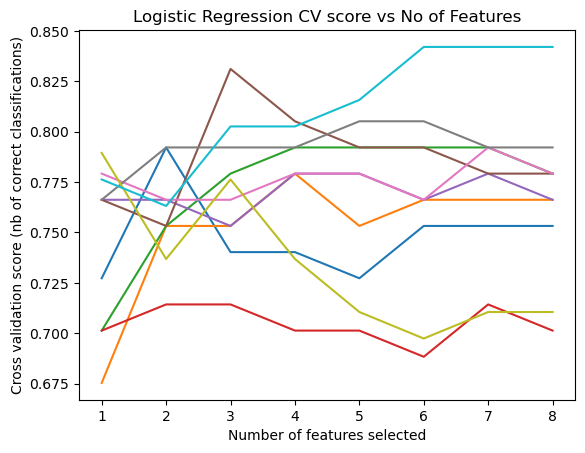

In [11]:
plt.figure()
plt.title('Logistic Regression CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [12]:
feature_names = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

feature_importance = list(zip(feature_names, rfecv.support_))
new_features = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features.append(value[0])
        
print(new_features)

['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Here we infer that, all predictor variables present in dataset except skin thickness are contributing significantly towards outcome variable in LR model. It seems that skin thickness is recursive feature for the LR model and hence got removed. By taking these seven features into consideration, we will again check the accuracy of LR model.


We can do a comparison of the LR model with original features and the RFECV selected features to see if there is an improvement in the accuracy scores.


In [14]:
new_features=['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_X_median= pd.DataFrame(X_median_scaled)
df_X_median.columns=diabetes_df_median.columns[:-1]
df_X_median.head(2)
df_X_median[['Pregnancies', 'Glucose', 'BloodPressure', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
df_X_median.isnull().sum()
X_median_new = df_X_median[new_features]

In [15]:
# Calculate accuracy scores

initial_score = cross_val_score(logreg_model, X_median_scaled, y_median, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(logreg_model, X_median_new, y_median, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7669514695830485 
Accuracy after Feature Selection : 0.7721462747778538 


Here we see that accuracy of LR classifier having all predictor variables except skin thickness is increased from 76.69% to 77.21%. Although this increase is small and there is slight difference in accuracy scores of LR model with original features & the RFECV, yet we can say that skin thickness predictor was not contributing much towards response variable

# GB -Feature Selection

We can also study the 2nd best model (GB), to see if features selection process increases the model accuracy and if it would be better than GB after the process.

/Users/promilasharan/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


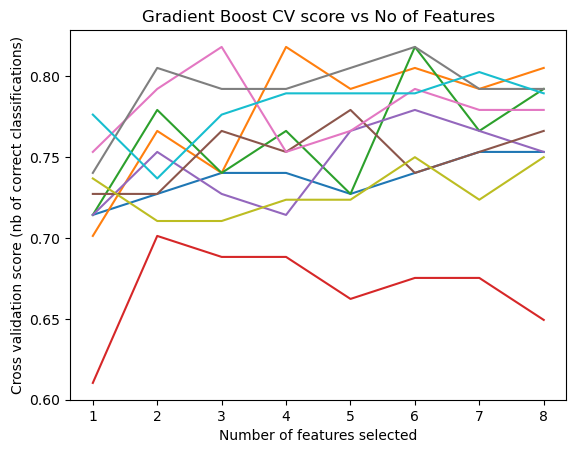

In [17]:
gb_model = GradientBoostingClassifier()
gb_rfecv = RFECV(estimator=gb_model, step=1, cv=skfold, scoring='accuracy')
gb_rfecv.fit(X_median_scaled, y_median)
plt.figure()
plt.title('Gradient Boost CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(gb_rfecv.grid_scores_) + 1), gb_rfecv.grid_scores_)
plt.show()

In [18]:
feature_importance = list(zip(feature_names, gb_rfecv.support_))
new_features_median = []
for key,value in enumerate(feature_importance):
    if(value[1]) == True:
        new_features_median.append(value[0])
        
print(new_features_median)

['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']


Here we infer that, following six features- number of pregnancies, glucose, insulin, BMI, DPF & age are contributing significantly towards outcome variable in GB model. It seems that BP & skin thickness predictors are recursive features for the GB model and hence got removed. 
By taking these six features into consideration, we will again check the accuracy of GB model and see if the accuracy may be higher than the LR model or not.
We can do a comparison of the LR model with original features and the RFECV selected features to see if there is an improvement in the accuracy scores. 


In [20]:
new_features=['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

df_X_median= pd.DataFrame(X_median_scaled)
df_X_median.columns=diabetes_df_median.columns[:-1]
df_X_median.head(2)
df_X_median[['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']]
df_X_median.isnull().sum()
X_median_new = df_X_median[new_features]

In [21]:
initial_score = cross_val_score(gb_model, X_median_scaled, y_median, cv=skfold, scoring='accuracy').mean()
print("Initial accuracy : {} ".format(initial_score))
fe_score = cross_val_score(gb_model,X_median_new , y_median, cv=skfold, scoring='accuracy').mean()
print("Accuracy after Feature Selection : {} ".format(fe_score))

Initial accuracy : 0.7656356801093643 
Accuracy after Feature Selection : 0.7682330827067669 


We can conclude that there is slight increase in accuracy of GB classifier (from 76.56 % to 76.82%) after taking into consideration the above mentioned six predictors. So we can conclude for GB model is that these six features are more contributing to the outcome variable as removing of two recursive features increased its accuracy.
But still its accuracy is less than best performing model i.e., LR. So we will proceed with LR model for checking if Hyperparameter Tuning is increasing its accuracy or not..
In fact, its accuracy become more than GB. So we will proceed with LR for Hyperparameter Tuning.

# Hyperparameter Tuning of LR

In [22]:
# Specify parameters
c_values = list(np.arange(1, 10))
param_grid = [
    {'C': c_values, 'penalty': ['l1'], 'solver' : ['liblinear'], 'multi_class' : ['ovr']},
    {'C': c_values, 'penalty': ['l2'], 'solver' : ['liblinear', 'newton-cg', 'lbfgs'], 'multi_class' : ['ovr']}
]

In [23]:
grid = GridSearchCV(LogisticRegression(), param_grid, cv=skfold, scoring='accuracy')
grid.fit(X_median_new, y_median)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=LogisticRegression(),
             param_grid=[{'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'multi_class': ['ovr'], 'penalty': ['l1'],
                          'solver': ['liblinear']},
                         {'C': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                          'multi_class': ['ovr'], 'penalty': ['l2'],
                          'solver': ['liblinear', 'newton-cg', 'lbfgs']}],
             scoring='accuracy')

In [24]:
print(grid.best_params_)
print(grid.best_estimator_)

{'C': 2, 'multi_class': 'ovr', 'penalty': 'l1', 'solver': 'liblinear'}
LogisticRegression(C=2, multi_class='ovr', penalty='l1', solver='liblinear')


The best hyperparameters are displayed above. We can feed the best parameters into the Logistic Regression model and observe if the model's accuracy has improved.

In [25]:
logreg_new = LogisticRegression(C=1, multi_class='ovr', penalty='l1', solver='liblinear')
initial_score = cross_val_score(logreg_new, X_median_new, y_median, cv=skfold, scoring='accuracy').mean()
print("Final accuracy : {} ".format(initial_score))

Final accuracy : 0.7708133971291866 
